In [85]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
from scipy.stats import gamma
import matplotlib.pyplot as plt

%matplotlib inline

# Measurement Error Experiments

We are interested in finding the causal effect of Tutoring $T$ on graduation rate $G$. Let's say that richer people are more likely to take $T$ than their poorer counterparts. In other words, socioeconomic status ($S$) is a common cause of treatment and outcome. For this experiment, we'll assume a toy problem -- we assume that the only cause of $T$ is $S$. We'll assume we know the population parameters apriori and generate a data set given those population parameters and see if we could recover the causal effect of $T$ on $G$.

![Causal Diagram with Measurement Error on Unobserved Confounder](./img/dag.png)


For non-time-varying treatments, the standard adjustment formula would say that we could get an unbiased estimate of the effect of $T$ on $G$ as follows:

$$
\begin{equation}
\begin{aligned}
  P(G \mid do(t)) &= \sum_{s} P(G \mid t, s) \cdot P(s)
\end{aligned}
\end{equation}
$$

However, in some data sets, we might not have access to $S$, but we might have access to a proxy, such as Free/Reduced Lunch $F$. 

## Question of Interest

Given that $S$ is unobserved, could we still have a good guess of what the causal effect of $T$ on $G$ is?
Let's assume that we have reasonable priors on $P(f \mid s)$ and $s$.





## Generate Synthetic Dataset

### Socioeconomic Status

Let's say socioeconomic status is defined as household income. In reality, household income is just a measure of socioeconomic status, since it doesn't take into account inheritance -- one could technically be wealthy while having 0 household income. However, for the sake of simplicity of this experiment, we'll equate household income with socioeconomic status. Looking at [statisticalatlas.com](https://statisticalatlas.com/state/Massachusetts/Household-Income), we can make a realistic model of income of people in Massachusetts.

![Household Income](./img/household-incomes.png)

We could model household income for people in Massachusetts as a [gamma distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html). I thought of using the gamma distribution after looking at this graph because 

1. Household income is continuous. 
2. The lower bound of income is 0.
3. Household income distribution is skewed towards the left.
4. Some people have really high incomes relative to most (fat tail).

After tuning some parameters by hand, I felt like I ended up with a model that can generate similar-enough data, at least for most of the people that are not in the extremes. Given the parameters below, my model's mapping of income to percentile seems to match the one provided by the Statistical Atlas graph above.

In [86]:
socioeconomic_status = pd.Series(np.random.gamma(shape=1.7, scale=53000, size=1000))

In [87]:
percentile_income = {
    95: 250000,
    80: 142000,
    60: 89900,
    50: 71000,
    40: 54300,
    20: 26000
}

In [88]:
def print_percentiles(percentile_income, socioeconomic_status):
    for percentile in percentile_income:

        #socioeconomic_status > percentile_income[percentile]
        print(
            "Income: " + str(percentile_income[percentile]) + \
            ". Statistical Atlas Percentile: " + str(percentile) + \
            ". My Gamma Model Percentile: " + \
                str(1 - (socioeconomic_status > percentile_income[percentile]).mean()) )

In [89]:
socioeconomic_status.var()

5142472338.528737

In [90]:
print_percentiles(percentile_income, socioeconomic_status)

Income: 250000. Statistical Atlas Percentile: 95. My Gamma Model Percentile: 0.96
Income: 142000. Statistical Atlas Percentile: 80. My Gamma Model Percentile: 0.789
Income: 89900. Statistical Atlas Percentile: 60. My Gamma Model Percentile: 0.597
Income: 71000. Statistical Atlas Percentile: 50. My Gamma Model Percentile: 0.479
Income: 54300. Statistical Atlas Percentile: 40. My Gamma Model Percentile: 0.352
Income: 26000. Statistical Atlas Percentile: 20. My Gamma Model Percentile: 0.124


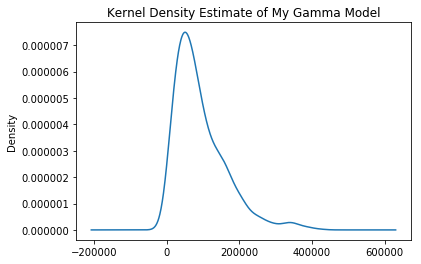

In [91]:
pd.Series(socioeconomic_status).plot.kde(title='Kernel Density Estimate of My Gamma Model')

### Generate Treatment

Richer people are more likely to receive tutoring. Students with higher socioeconomic status are more likely to take up tutoring.

In [92]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

In [93]:
logistic(0.5)

0.6224593312018546

In [94]:
true_tutoring_alpha = -0.3
true_socioecon_to_tutoring_coeff = 0.000001

In [95]:
tutoring = np.random.binomial(
    n=1,
    p=logistic(
        socioeconomic_status * true_socioecon_to_tutoring_coeff + true_tutoring_alpha
    )
)

### Generate Outcome

We'll assume that wealthy students are more likely to graduate. We'll also assume that getting tutored, on average, increases the probability of graduating by 10%.

In [96]:
tutoring_coeff = 1.5
socioecon_coeff = 0.00001
graduation = logistic(tutoring * tutoring_coeff + socioeconomic_status * socioecon_coeff)

### Generate Free/Reduced Lunch

We'll have a simple rule: If income is less than \$35,000, then student has free/reduced lunch.

In [97]:
free_reduced_lunch = (socioeconomic_status < 35000) * 1

### Create the Dataframe

In [98]:
df = pd.DataFrame(
    {
        'tutoring': tutoring,
        'socioeconomic_status': socioeconomic_status,
        'free_reduced_lunch': free_reduced_lunch,
        'graduation': graduation
    }
)

70000 = alpha / beta

4,635,000,000 = alpha / beta^2

70000 * beta = alpha

4,635,000,000 = 70000 / beta

beta = 70000 / 4,635,000,000

alpha = 10.57


In [99]:
70000 / 4635000000 * 70000

1.0571736785329018

### gamma_alpha

alpha / beta = 10.57

alpha / beta^2 = 0.25

alpha = 0.25 * beta^2

0.25 * beta^2 / beta = 10.57

0.25 * beta = 10.57

beta = 10.57 * 4 = 42.28

alpha / 42.28 = 10.57

alpha = 10.57 * 42.28

alpha = 446.89

### gamma_beta

alpha / beta = 0.00015
alpha / beta^2 = 0.001

alpha = 0.00015 * beta

beta^2 = alpha / 0.001
beta^2 = 0.00015 * beta / 0.001
beta^2 = 0.15 * beta

beta = 0.15
alpha = 0.00015 * 0.15 = 0.0000225

In [100]:
with pm.Model() as gamma_model:
    gamma_alpha = pm.Gamma('gamma_alpha', mu=1.0571736785329018, sigma=0.0005)
    gamma_beta = 0.000015102481121898598

    socioeconomic_status = pm.Gamma('socioeconomic_status', alpha=gamma_alpha, beta=gamma_beta)
    gamma_prior_predictive = pm.sample_prior_predictive(samples=2000)

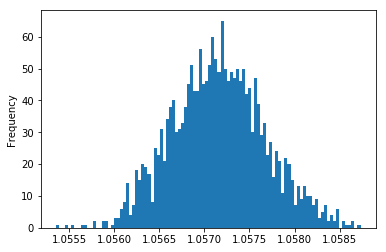

In [101]:
pd.Series(gamma_prior_predictive['gamma_alpha']).plot.hist(bins=100)

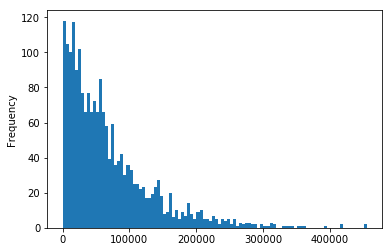

In [102]:
pd.Series(gamma_prior_predictive['socioeconomic_status']).plot.hist(bins=100)

In [103]:
gamma_prior_predictive['socioeconomic_status'].mean()

68484.06236362761

In [61]:
gamma_prior_predictive['socioeconomic_status'].var()

4293136392.8752637

In [62]:
print_percentiles(percentile_income, gamma_prior_predictive['socioeconomic_status'])

Income: 250000. Statistical Atlas Percentile: 95. My Gamma Model Percentile: 0.976
Income: 142000. Statistical Atlas Percentile: 80. My Gamma Model Percentile: 0.876
Income: 89900. Statistical Atlas Percentile: 60. My Gamma Model Percentile: 0.743
Income: 71000. Statistical Atlas Percentile: 50. My Gamma Model Percentile: 0.652
Income: 54300. Statistical Atlas Percentile: 40. My Gamma Model Percentile: 0.5509999999999999
Income: 26000. Statistical Atlas Percentile: 20. My Gamma Model Percentile: 0.29200000000000004


In [63]:
df.socioeconomic_status

0       18572.857478
1      146802.415052
2       24762.176319
3      148526.338162
4        4519.449476
5       49260.910802
6      199833.659857
7       77687.004861
8       24203.559628
9       96622.785850
10     122781.547479
11      51472.963799
12      82854.860657
13      38555.725526
14      23196.622127
15     145451.778775
16     129345.229458
17      45662.177186
18      44455.292695
19      98718.310666
20      81486.723126
21      32191.407290
22      45274.164547
23      90408.845333
24     139264.173557
25     117751.506113
26     139528.993131
27     106953.054195
28      69630.551282
29     248214.117734
           ...      
970     49756.746248
971     74756.044159
972     68269.099336
973     94997.715666
974    284039.587093
975    220262.878758
976     59268.685953
977    183160.494409
978     41806.599856
979    187654.600362
980    233986.413638
981    110103.195633
982     55388.674211
983     57363.493757
984    163671.762796
985     27668.235538
986     88773

In [111]:
with pm.Model() as model:
    gamma_alpha = 10.57
    gamma_beta = 0.00015102481121898598
    
    tutoring_to_grad_coeff = pm.Normal('tutoring_coeff', mu=0, sigma=0.5)
    socioecon_to_grad_coeff = pm.Normal('socioecon_coeff', mu=0, sigma=0.00001)
    socio_to_tutoring_coeff = pm.Normal('socio_to_tutoring_coeff', mu=0, sigma=0.00001)
    tutoring_alpha = pm.Normal('tutoring_alpha', mu=0, sigma=0.5)
    
    socioeconomic_status = pm.Gamma(
        'socioeconomic_status', 
        alpha=gamma_alpha, 
        beta=gamma_beta, 
        shape=df.shape[0], 
        observed=df['socioeconomic_status']
    )
    p_tutoring = logistic(socioeconomic_status * socio_to_tutoring_coeff + tutoring_alpha)

    tutoring = pm.Binomial('tutoring', n=1, p=p_tutoring, observed=df['tutoring'], shape=df.shape[0])

    p_free_reduced_lunch = logistic(socioeconomic_status - 35000)

    # commenting out this line below makes the model run but leads to the incorrect inference 
    # that tutoring decreases graduation rates
    pm.Binomial(
        'free_reduced_lunch', 
        n=1, 
        p=p_free_reduced_lunch, 
        observed=df['free_reduced_lunch'], 
        shape=df.shape[0]
    )

    p_graduation = logistic(tutoring * tutoring_to_grad_coeff + socioeconomic_status * socioecon_to_grad_coeff)
    graduation = pm.Binomial('graduation', n=1, p=p_graduation, observed=df['graduation'], shape=df.shape[0])
    
        
    traces = pm.sample(init='adapt_diag', tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tutoring_alpha, socio_to_tutoring_coeff, socioecon_coeff, tutoring_coeff]
Sampling 4 chains, 0 divergences:   0%|          | 0/6000 [00:00<?, ?draws/s]/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling 4 chains, 0 divergences:   0%

ParallelSamplingError: Bad initial energy

In [112]:
model.check_test_point()

tutoring_coeff                -0.23
socioecon_coeff               10.59
socio_to_tutoring_coeff       10.59
tutoring_alpha                -0.23
socioeconomic_status      -14743.19
tutoring                    -693.15
free_reduced_lunch             -inf
graduation                  -693.15
Name: Log-probability of test_point, dtype: float64

/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12d1f7690>],
      dtype=object)

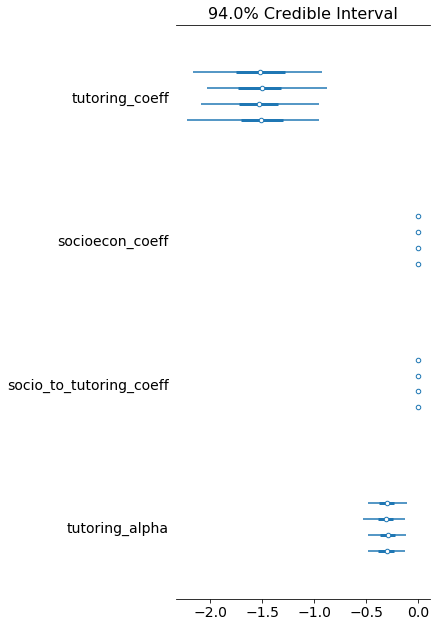

In [106]:
pm.forestplot(traces, varnames=['tutoring_coeff', 'socioecon_coeff', 'socio_to_tutoring_coeff', 'tutoring_alpha'])

/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12cd84750>,
      dtype=object)

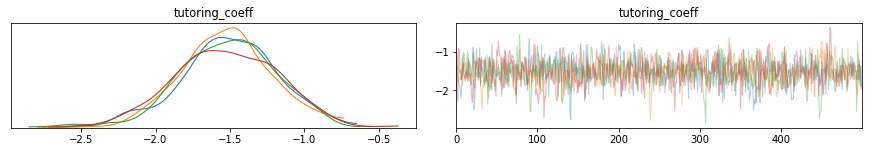

In [107]:
pm.traceplot(traces, varnames=['tutoring_coeff'])

In [108]:
traces.varnames

['tutoring_coeff',
 'socioecon_coeff',
 'socio_to_tutoring_coeff',
 'tutoring_alpha']

/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1305f5bd0>,
      dtype=object)

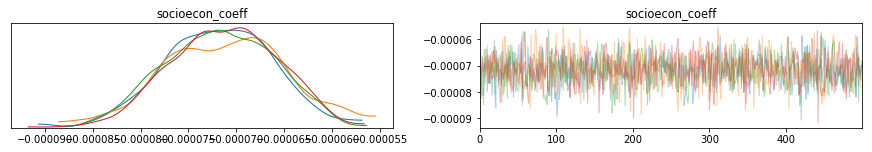

In [109]:
pm.traceplot(traces, varnames=['socioecon_coeff'])

/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1303c92d0>,
      dtype=object)

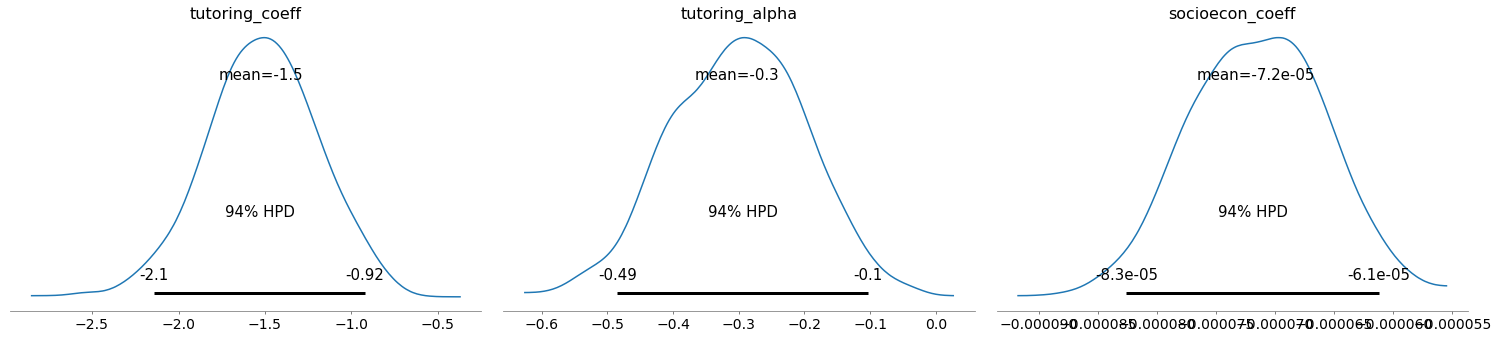

In [110]:
pm.plot_posterior(traces, varnames=['tutoring_coeff', 'tutoring_alpha', 'socioecon_coeff'])